# Extra task: uncertainty
Use Monte Carlo Dropout to estimate classification confidence. 
Compare dropout to an ensemble of CNN networks (e.g.: do individual dropout subnetworks point to the same, or different local minima?)

Great article to get familiar with the topic: [link](https://medium.com/@ciaranbench/monte-carlo-dropout-a-practical-guide-4b4dc18014b5).

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import matplotlib.pyplot as plt
from keras.api.utils import image_dataset_from_directory
import numpy as np
import tensorflow as tf
import keras
from keras.api.optimizers import SGD
from keras.api.callbacks import EarlyStopping, TensorBoard
from keras.api.optimizers.schedules import ExponentialDecay
from keras.api.losses import CategoricalCrossentropy
from keras.api.metrics import CategoricalAccuracy

DATA_PATH = os.path.join(os.getcwd(), "..", "data")
MODEL_PATH = os.path.join(os.getcwd(), "..", "models")
LOG_DIR = os.path.join(os.getcwd(), "..", "logs")

2025-01-11 16:42:24.539574: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 16:42:24.555266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 16:42:24.573815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 16:42:24.579136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 16:42:24.594077: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset_path = os.path.join(DATA_PATH, "kaggle-speech-recognition")
batch_size = 128
class_names = next(os.walk(os.path.join(dataset_path, "train")))[1]
class_dict = dict(zip(class_names, range(len(class_names))))

ds_valid: tf.data.Dataset  = image_dataset_from_directory(os.path.join(dataset_path, "validation"), color_mode="grayscale",
                                        label_mode="categorical", batch_size=batch_size, class_names=class_names,
                                        seed=42, validation_split=0.0)

ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

Found 6798 files belonging to 30 classes.


I0000 00:00:1736610147.450192     969 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736610147.517645     969 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736610147.517691     969 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736610147.522144     969 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736610147.522194     969 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

The architecture of the model is AlexNet, since by convention it has dropout layers in the dense tail. Therefore it fits nicely with out goal here.

In [3]:
def model(
        normalization_layer = None,
        dropout_rate = 0.5,
        input_shape = (256, 256),
        batch_size = 128
):
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    if normalization_layer is not None:
        x = normalization_layer(x)
    x = keras.layers.RandomCrop(height=227, width=227)(x)

    # Convolutional layers
    # Instead of 11x11 stride 4 we are going to use subsequent 3x3 layers
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(256, kernel_size=(2, 2), strides=2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(256, kernel_size=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)


    # Dense tail
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="MyAlexNet")

Load pretrained ensemble models and let the first ensemble model be the model used in monte carlo dropout method.

In [9]:
ensembles = [keras.models.load_model(f"../models/ensembles/MyAlexNet_{i}.keras") for i in range(5)]
mcd_model = ensembles[0]

Following functions allow to calculate and plot accuracies of the model in certain confidence intervals.

In [11]:
def multiclass_calibration_curve(probs: np.ndarray, labels: np.ndarray, bins: int):
    edges = np.linspace(0.0, 1.0, bins + 1, dtype=np.float32)

    midpoints = []
    accuracies = []
    mean_confidences = []

    for i in range(bins):
        start = edges[i]
        end = edges[i + 1]
        midpoint = (start + end) / 2

        mask = (probs >= start) & (probs < end)
        count = mask.sum()
        accuracy = labels[mask].sum() / count
        mean_confidence = probs[mask].mean()

        midpoints.append(midpoint)
        accuracies.append(accuracy)
        mean_confidences.append(mean_confidence)

    return midpoints, accuracies, mean_confidences


def plot_multiclass_calibration_curve(probs, labels, bins=10, title=None):
    if title is None:
        title = "Reliability diagram"

    midpoints, accuracies, mean_confidences = multiclass_calibration_curve(probs, labels, bins=bins)
    plt.bar(midpoints, accuracies, width=1.0/float(bins), align='center', lw=1, ec='#000000', fc='#2233aa', alpha=1, label='Model', zorder=0)
    plt.scatter(midpoints, accuracies, lw=2, ec='black', fc="#ffffff", zorder=2)
    plt.plot(np.linspace(0, 1.0, 20), np.linspace(0, 1.0, 20), '--', lw=2, alpha=.7, color='gray', label='Perfectly calibrated', zorder=1)
    plt.xlim(0.0, 1.05)
    plt.ylim(0.0, 1.05)
    plt.xlabel('\nconfidence')
    plt.ylabel('accuracy\n')
    plt.title(title+'\n')
    plt.xticks(midpoints, rotation=-45)
    plt.legend(loc='upper left')
    return midpoints, accuracies, mean_confidences

Model training functions (if you would like to train your own).

In [7]:
def train(model: keras.Model, ds_train: tf.data.Dataset, ds_valid: tf.data.Dataset, ensemble_id: int):
    lr_scheduler = ExponentialDecay(0.01, decay_steps=10_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler, momentum=0.9)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss,
                  metrics=[CategoricalAccuracy(name="categorical_accuracy")])

    early_stopping = EarlyStopping(patience=15, restore_best_weights=True, start_from_epoch=5)
    log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", model.name)
    model_log_dir = os.path.join(log_dir, f"ensemble_{ensemble_id}")
    tensorboard_cb = TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    model.fit(ds_train, validation_data=ds_valid, epochs=35, verbose=0,
              callbacks=[early_stopping, tensorboard_cb])
    return model


def training_models(ensembles, ds_train, ds_valid):
    os.makedirs("../models/ensembles", exist_ok=True)

    for i, model in enumerate(ensembles):
        print("Training ensemble num", i)
        model = train(model, ds_train, ds_valid, i)
        model.save(f"../models/ensembles/{model.name}_{i}.keras")

Following functions calculate kl divergence of either monte carlo or ensemble method.

In [34]:
def KL_div(P, Q):
    return -np.sum(P * np.log(Q / P))


def probs_per_class(X: np.ndarray):
    class_counts = np.sum(X, axis=0)
    return class_counts / np.sum(class_counts)


def get_kl_divergence(Y: np.ndarray, Y_probs: np.ndarray, class_num: int = 30):
    P = probs_per_class(Y)
    Y_pred_ohe = np.eye(class_num)[np.argmax(Y_probs, axis=1)]
    Q = probs_per_class(Y_pred_ohe)

    return KL_div(P, Q)


def get_calibration_stats(Y: np.ndarray, Y_probs: np.ndarray, title: str):
    midpoints, accuracies, _ = plot_multiclass_calibration_curve(Y_probs, Y, title="MCD reliability diagram")
    kl_div = get_kl_divergence(Y, Y_probs)
    print("KL divergence value is ", kl_div)

    accuracy_error = np.array(accuracies, dtype=np.float32) - np.array(midpoints, dtype=np.float32)
    mse_accuracy = np.average(accuracy_error.dot(accuracy_error))
    print("Mean squarred error of accuracies is ", mse_accuracy)

In [16]:
def predict_mc_dropout(model: keras.Model, x: np.ndarray, sample=20):
    y_hat_arr = []
    for _ in range(sample):
        y_hat = model(x, training=True).numpy()
        y_hat_arr.append(y_hat)

    y_hat_arr = np.stack(y_hat_arr, axis=0)
    y_probs = tf.reduce_mean(y_hat_arr, axis=0).numpy()

    return y_probs

Y_probs_mcd = []
Y_mcd = []
for x, y in ds_valid:
    y_probs_mcd = predict_mc_dropout(mcd_model, x)
    Y_probs_mcd.append(np.array(y_probs_mcd))
    Y_mcd.append(y)

Y_probs_mcd = np.concatenate(Y_probs_mcd, axis=0)
Y_mcd = np.concatenate(Y_mcd, axis=0)

KL divergence value is  0.001779529664052415
Mean squarred error of accuracies is  0.21417096


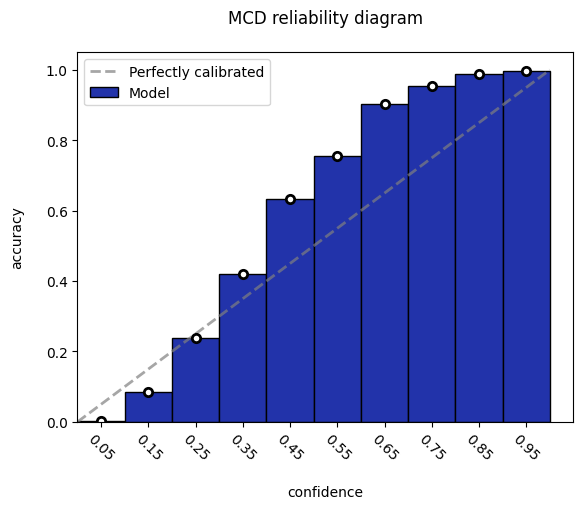

In [37]:
get_calibration_stats(Y_mcd, Y_probs_mcd, title="MCD reliability diagram")

In [36]:
def predict_ensembles(ensembles: list[keras.Model], x: np.ndarray):
    y_hat_arr = []
    for model in ensembles:
        y_hat = model(x, training=False).numpy()
        y_hat_arr.append(y_hat)

    y_hat_arr = np.stack(y_hat_arr, axis=0)
    y_probs = tf.reduce_mean(y_hat_arr, axis=0).numpy()

    return y_probs

Y_probs_ens = []
Y_ens = []
for x, y in ds_valid:
    y_probs = predict_ensembles(ensembles, x)
    Y_probs_ens.append(np.array(y_probs))
    Y_ens.append(y)

Y_probs_ens = np.concatenate(Y_probs_ens, axis=0)
Y_ens = np.concatenate(Y_ens, axis=0)

2025-01-11 17:04:10.620135: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


KL divergence value is  0.003716254063095843
Mean squarred error of accuracies is  0.08212566


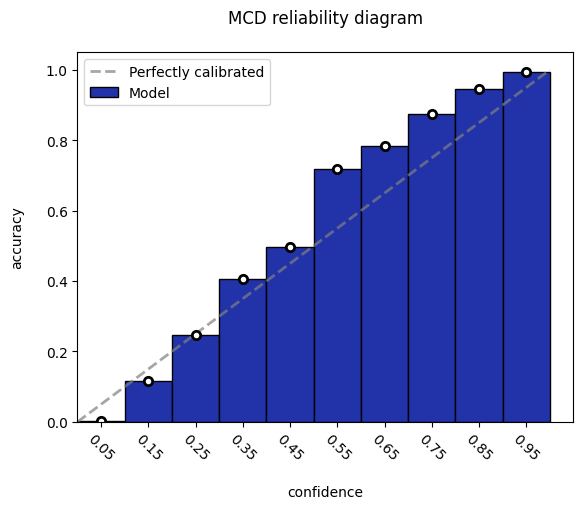

In [38]:
get_calibration_stats(Y_ens, Y_probs_ens, title="Ensembles reliability diagram")